# Understanding Autocorrelation: The Memory of Time Series

## Learning Objectives
By the end of this notebook, you will be able to:
1. Understand what autocorrelation means in plain language
2. Read and interpret ACF (Autocorrelation Function) plots
3. Read and interpret PACF (Partial Autocorrelation Function) plots
4. Understand how ACF/PACF help with ARIMA parameter selection
5. Use autocorrelation to identify patterns in time series data


## Introduction: What is Autocorrelation?

**Autocorrelation** measures how much past values influence future values. It's the "memory" of your time series.

**Simple explanation:** Autocorrelation tells you if today's value is related to yesterday's value, last week's value, last month's value, etc.

**Think of it like this:**
- **High autocorrelation at lag 1:** Today is strongly related to yesterday
- **High autocorrelation at lag 12 (monthly data):** This month is strongly related to the same month last year (seasonality!)
- **Low autocorrelation:** Past values don't help predict future values

**Real-World Example:** 
- Stock prices often have high autocorrelation at lag 1 (today's price is related to yesterday's)
- Sales data might have high autocorrelation at lag 12 (this December is related to last December)

**Why it matters:** Autocorrelation helps us understand:
1. How much "memory" the data has
2. What lags (past time periods) matter most
3. Whether there's seasonality
4. What ARIMA parameters to use

**Think About It:** If you're forecasting tomorrow's temperature, would yesterday's temperature be more useful than last year's temperature? (Yes! That's autocorrelation at work.)


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plotting style
plt.style.use('default')

print("Libraries imported successfully")


Libraries imported successfully


In [12]:
# Load and prepare the data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Make data stationary for better autocorrelation analysis
# (We learned this in the previous notebook)
data['Passenger_Log'] = np.log(data['#Passengers'])
data['Passenger_Stationary'] = data['Passenger_Log'].diff().dropna()

print("✅ Data loaded and made stationary")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Stationary data points: {len(data['Passenger_Stationary'])}")


✅ Data loaded and made stationary
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Stationary data points: 144


## Section 1: Understanding Autocorrelation (ACF)

### What is ACF?

**ACF (Autocorrelation Function)** measures the correlation between a time series and lagged versions of itself.

**What are lags?**
- **Lag 1:** Correlation between today and yesterday
- **Lag 2:** Correlation between today and 2 days ago
- **Lag 12 (monthly data):** Correlation between this month and same month last year

**How to interpret ACF values:**
- **Close to 1:** Strong positive relationship (if yesterday was high, today is likely high)
- **Close to -1:** Strong negative relationship (if yesterday was high, today is likely low)
- **Close to 0:** No relationship (yesterday doesn't help predict today)

**Think of it like this:** ACF tells you "how much does the past matter?"

### Creating an ACF Plot

Let's create an ACF plot to see the autocorrelation patterns:


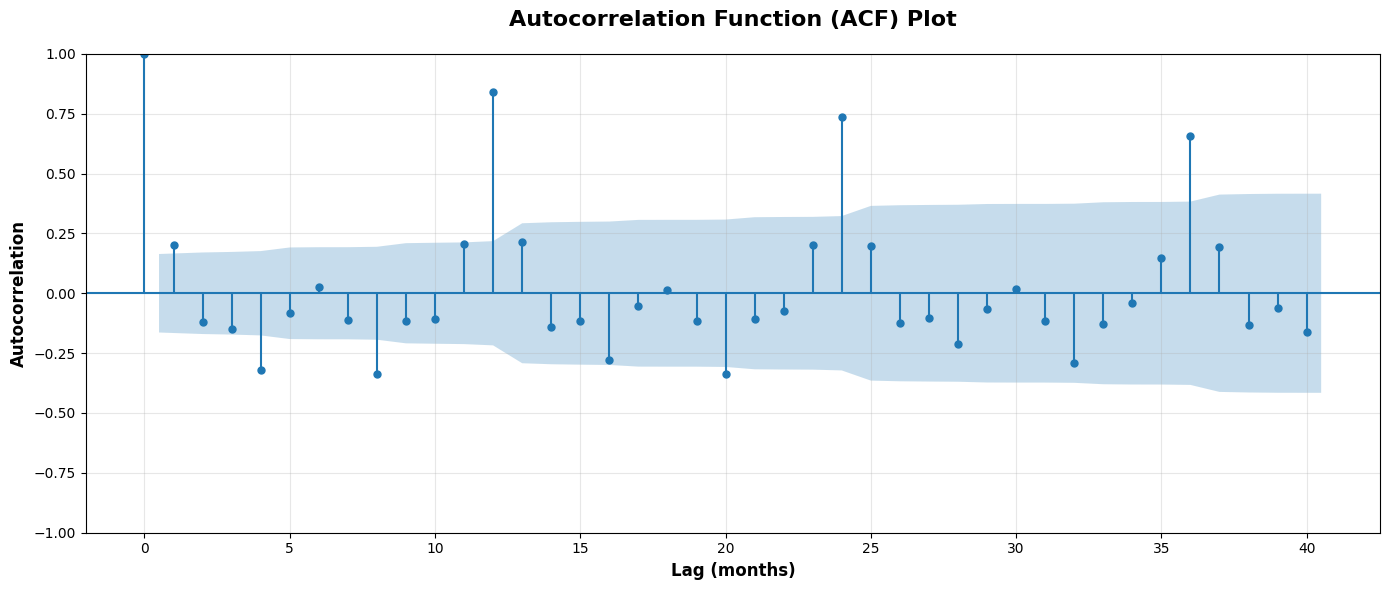


📊 How to Read This Plot:
✅ Each bar shows correlation at that lag
✅ Blue shaded region = not statistically significant (can ignore)
✅ Bars outside blue region = statistically significant (matter for forecasting)
✅ Lag 0 is always 1.0 (data is perfectly correlated with itself)

💡 Look for patterns:
   - High bars at lag 12, 24, 36 = yearly seasonality
   - Slowly decreasing bars = trend (but we removed that)
   - Bars staying high = strong memory (past values matter a lot)


In [13]:
# Plot ACF for the stationary data
plt.figure(figsize=(14, 6))
plot_acf(data['Passenger_Stationary'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) Plot', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Lag (months)', fontsize=12, fontweight='bold')
plt.ylabel('Autocorrelation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 How to Read This Plot:")
print("✅ Each bar shows correlation at that lag")
print("✅ Blue shaded region = not statistically significant (can ignore)")
print("✅ Bars outside blue region = statistically significant (matter for forecasting)")
print("✅ Lag 0 is always 1.0 (data is perfectly correlated with itself)")
print("\n💡 Look for patterns:")
print("   - High bars at lag 12, 24, 36 = yearly seasonality")
print("   - Slowly decreasing bars = trend (but we removed that)")
print("   - Bars staying high = strong memory (past values matter a lot)")


### Interpreting the ACF Plot

**What we can see:**

1. **Lag 1 is high:** Today is strongly related to yesterday (strong short-term memory)

2. **Peaks at lags 12, 24, 36:** These are multiples of 12 months - this confirms yearly seasonality!

3. **Slowly decreasing pattern:** Even after removing trend, there's still some pattern (this is normal)

4. **Many significant lags:** Past values matter for a long time (about 15-20 lags are significant)

**Business Insight:** This data has strong "memory" - past passenger counts help predict future counts. The seasonal pattern (lag 12) is very strong, which makes sense for airline data (summer always busy, winter always slow).

**Think About It:** Why do you think lag 12 (one year) would be important for monthly airline passenger data?


## Section 2: Understanding Partial Autocorrelation (PACF)

### What is PACF?

**PACF (Partial Autocorrelation Function)** is similar to ACF, but it removes the effect of intermediate lags.

**Key difference from ACF:**
- **ACF:** Shows total correlation (including indirect effects)
- **PACF:** Shows direct correlation only (removes indirect effects)

**Think of it like this:**
- **ACF at lag 2:** Correlation between today and 2 days ago (includes the effect of yesterday)
- **PACF at lag 2:** Direct correlation between today and 2 days ago (removes yesterday's effect)

**Why it matters:** PACF helps identify which lags have direct relationships, not just indirect ones through other lags.

### Creating a PACF Plot

Let's create a PACF plot and compare it to ACF:


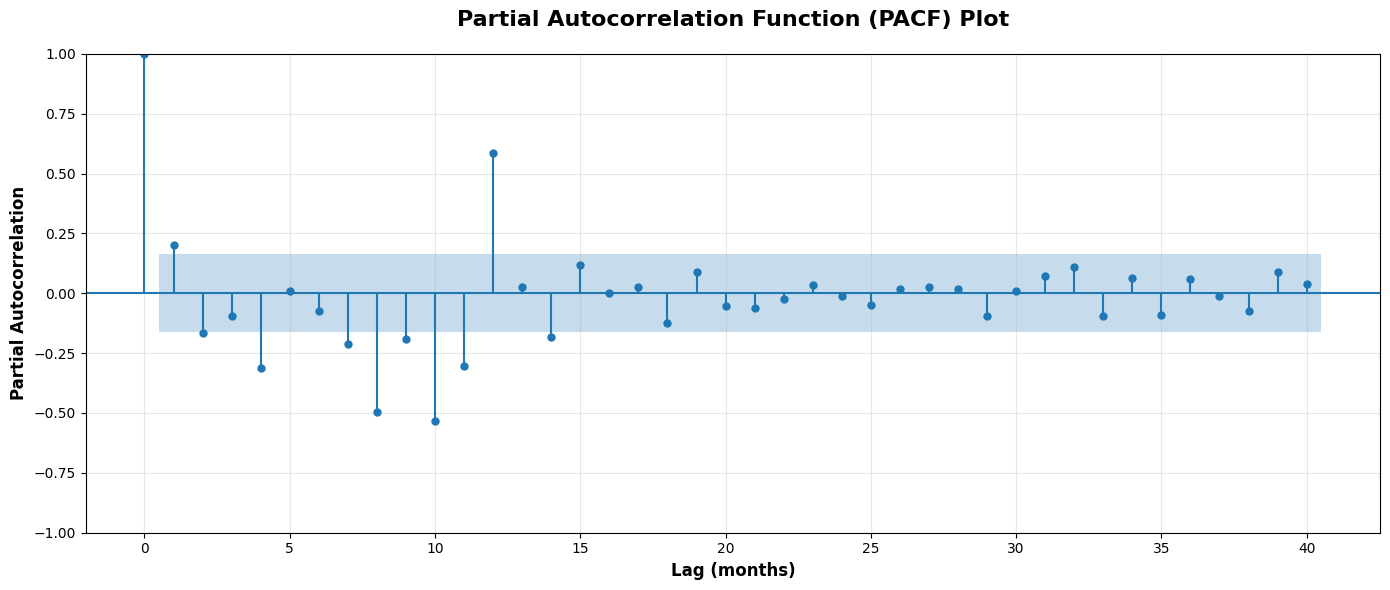


📊 How to Read This Plot:
✅ Similar to ACF, but shows DIRECT relationships only
✅ Blue shaded region = not statistically significant
✅ Bars outside blue region = direct relationships

💡 Key Difference from ACF:
   - PACF cuts off more quickly (fewer significant lags)
   - This helps identify the ORDER of AR models
   - If PACF cuts off at lag 2, we might use AR(2)


In [14]:
# Plot PACF for the stationary data
plt.figure(figsize=(14, 6))
plot_pacf(data['Passenger_Stationary'].dropna(), lags=40, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) Plot', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Lag (months)', fontsize=12, fontweight='bold')
plt.ylabel('Partial Autocorrelation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 How to Read This Plot:")
print("✅ Similar to ACF, but shows DIRECT relationships only")
print("✅ Blue shaded region = not statistically significant")
print("✅ Bars outside blue region = direct relationships")
print("\n💡 Key Difference from ACF:")
print("   - PACF cuts off more quickly (fewer significant lags)")
print("   - This helps identify the ORDER of AR models")
print("   - If PACF cuts off at lag 2, we might use AR(2)")


### Comparing ACF and PACF Side by Side

Let's see both plots together to understand the difference:


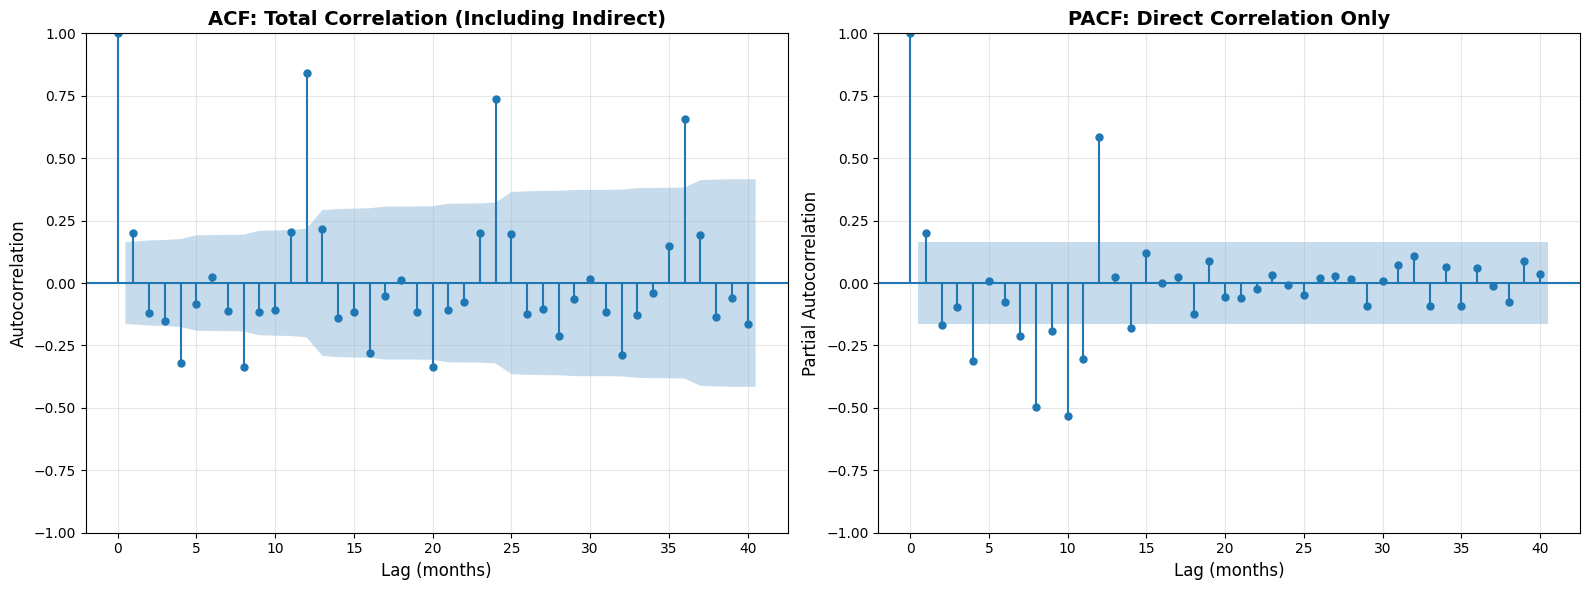


📊 Key Observations:
✅ ACF: Many significant lags (slowly decreasing)
✅ PACF: Fewer significant lags (cuts off more quickly)
✅ Both show strong seasonality at lag 12

💡 This pattern suggests we need ARIMA with seasonal components


In [15]:
# Plot both ACF and PACF side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot
plot_acf(data['Passenger_Stationary'].dropna(), lags=40, ax=ax1)
ax1.set_title('ACF: Total Correlation (Including Indirect)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Lag (months)', fontsize=12)
ax1.set_ylabel('Autocorrelation', fontsize=12)
ax1.grid(True, alpha=0.3)

# PACF plot
plot_pacf(data['Passenger_Stationary'].dropna(), lags=40, method='ywm', ax=ax2)
ax2.set_title('PACF: Direct Correlation Only', fontsize=14, fontweight='bold')
ax2.set_xlabel('Lag (months)', fontsize=12)
ax2.set_ylabel('Partial Autocorrelation', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("✅ ACF: Many significant lags (slowly decreasing)")
print("✅ PACF: Fewer significant lags (cuts off more quickly)")
print("✅ Both show strong seasonality at lag 12")
print("\n💡 This pattern suggests we need ARIMA with seasonal components")


## Section 3: How ACF/PACF Help with ARIMA

### Understanding ARIMA Parameters

ARIMA models have three parameters: **(p, d, q)**

- **p (AR - AutoRegressive):** How many past values to use
- **d (I - Integrated):** How many times to difference (we already did this!)
- **q (MA - Moving Average):** How many past errors to use

### How ACF/PACF Guide Parameter Selection

**For AR (p parameter):**
- Look at **PACF plot**
- Count how many lags are significant before it cuts off
- Example: If PACF is significant at lags 1, 2, 3, then p = 3

**For MA (q parameter):**
- Look at **ACF plot**
- Count how many lags are significant before it cuts off
- Example: If ACF is significant at lags 1, 2, then q = 2

**Important Note:** In practice, we'll use **auto-ARIMA** which finds these automatically. But understanding ACF/PACF helps you:
1. Understand what the model is doing
2. Interpret the results
3. Know when something might be wrong

**Think About It:** If PACF shows significant lags at 1, 2, and 12, what does that tell you about the data?


### Practical Example: Reading the Plots

Let's practice reading our ACF/PACF plots:

**From our ACF plot:**
- Many significant lags (up to about lag 15-20)
- Strong peaks at lags 12, 24, 36 (seasonality)
- Suggests we might need q = 12 or higher (but auto-ARIMA will figure this out)

**From our PACF plot:**
- Significant lags at 1, 2, and around 12
- Suggests we might need p = 2 or p = 12 (but auto-ARIMA will figure this out)

**Key Insight:** The strong seasonality (lag 12) suggests we need **SARIMA** (Seasonal ARIMA), not just regular ARIMA!

**Business Context:** This makes sense - airline passenger counts are strongly influenced by:
- Last month's count (lag 1)
- Last year's same month (lag 12)
- The overall trend (which we removed with differencing)


## Section 4: Common Patterns in ACF/PACF Plots

### Pattern 1: Strong Seasonality

**What you see:**
- High bars at regular intervals (e.g., every 12 months)
- ACF and PACF both show this pattern

**What it means:**
- Clear seasonal pattern
- Need seasonal models (SARIMA)

**Example:** Our airline data shows this at lag 12

### Pattern 2: Trend (Before Differencing)

**What you see:**
- ACF slowly decreases but stays high for many lags
- PACF might cut off quickly

**What it means:**
- Data has a trend
- Need differencing (d parameter)

**Example:** Most business data shows this before transformation

### Pattern 3: White Noise (Random)

**What you see:**
- All bars are small (close to zero)
- No significant lags

**What it means:**
- No patterns to forecast
- Past values don't help predict future
- Very hard to forecast!

**Example:** Truly random data (like lottery numbers)

### Pattern 4: Strong Short-Term Memory

**What you see:**
- High bars at lag 1, maybe lag 2
- Quickly drops to zero

**What it means:**
- Only recent past matters
- Simple models might work well

**Example:** Daily temperature (today is like yesterday, but not like last month)

**Think About It:** What pattern would you expect to see for daily website traffic data?


## Summary: Key Takeaways

This notebook introduced you to autocorrelation and how it helps with forecasting:

### What We Learned

1. **Autocorrelation (ACF):**
   - Measures how past values relate to current values
   - Shows total correlation (including indirect effects)
   - Helps identify seasonality and trends
   - Guides MA (q) parameter selection

2. **Partial Autocorrelation (PACF):**
   - Measures direct relationships only
   - Removes indirect effects
   - Cuts off more quickly than ACF
   - Guides AR (p) parameter selection

3. **Reading the Plots:**
   - Bars outside blue region = statistically significant
   - High bars = strong relationships
   - Patterns reveal seasonality and trends

4. **ARIMA Parameter Guidance:**
   - PACF helps choose p (AR parameter)
   - ACF helps choose q (MA parameter)
   - But auto-ARIMA does this automatically

### Key Insights

- **Memory matters:** Autocorrelation shows how much past affects future
- **Seasonality is visible:** Regular peaks in ACF/PACF reveal seasonal patterns
- **Visual interpretation:** Plots are easier to understand than numbers
- **Auto-ARIMA helps:** You don't need to manually count lags, but understanding helps!

### Why This Matters

Understanding autocorrelation helps you:
- Choose the right ARIMA parameters (conceptually)
- Understand what your model is doing
- Identify patterns in your data
- Interpret model results

**Remember:** ACF/PACF help you understand your data's "memory." The stronger the memory, the better ARIMA can forecast!
